In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import glob
import torch
from torch import nn
import torch.nn.functional as F
import  torch.optim as optim
from    matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.rc('font',family='Times New Roman', size=16)

In [2]:
device

device(type='cuda')

In [3]:
def convert_2d(df_dup):
    data_frame = pd.DataFrame()
    for i in range(0, df_dup.shape[0]-59):
        is_anomaly = False
        mylist = []
        for j in range(i, i+60):
            mylist.append(df_dup['value'].iat[j])
            if df_dup['is_anomaly'].iat[j] == 1:
                is_anomaly = True
        if is_anomaly:
            mylist.append(1)
        else:
            mylist.append(0)
        np_Array = np.array(mylist)
        mylist = np_Array.T
        data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
    return data_frame

In [4]:
def get_data():
    dataset_conc=[]
    path=r'Dataset'
    all_files=glob.glob(path+"/*.csv")
    for filename in all_files:
        df=pd.read_csv(filename,index_col=None,header=0)
        #将数据中value为0的替换成NaN
        df=df.replace(0,np.nan)
        #处理value那层数据，将0去除掉
        df=df.dropna(axis=0, how='any',subset=['value'])
        df.value = preprocessing.normalize([df.value]).T
        dataset_conc.append(convert_2d(df))
    frame=pd.concat(dataset_conc,axis=0,ignore_index=True)
    y = frame.iloc[:, 60]
    X = frame.iloc[:, 0:60]
    X_train = X[:int(X.shape[0] * 0.7)]
    X_test = X[int(X.shape[0] * 0.7):]
    y_train = y[:int(X.shape[0] * 0.7)]
    y_test = y[int(X.shape[0] * 0.7):]


    X_train = X_train.to_numpy()
    nrows, ncols = X_train.shape
    X_train = X_train.reshape(nrows, ncols, 1)

    X_test = X_test.to_numpy()
    nrows, ncols = X_test.shape
    X_test = X_test.reshape(nrows, ncols, 1)

    y_test = y_test.to_numpy()
    # print("X_train:",X_train.shape)
    #[62107,60,1]
    # print("y_train:",y_train.shape)
    #[62107,]
    return X_train,y_train,X_test,y_test

In [5]:
X_train,y_train,X_test,y_test=get_data()

In [6]:
# 定义实现因果卷积的类
from torch.nn.utils import weight_norm
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

# 定义了一个残差模块
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        # n_inputs:输入通道数
        # n_outputs:输出通道数
        # stride：步长
        # padding:填充长度
        # dilation：扩张率
        # 定义第一个空洞卷积层
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        # 根据第一个卷积层的输出与padding大小实现因果卷积
        self.chomp1 = Chomp1d(padding)
        # 添加激活函数与dropout正则化方法完成第一个卷积
        self.relu1 = nn.Softplus()
        self.dropout1 = nn.Dropout(dropout)

        # 堆叠同样结构的第二个卷积层
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.Softplus()
        self.dropout2 = nn.Dropout(dropout)

        # 将卷积模块的所有组建通过Sequential方法依次堆叠在一起
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        # 如果输出纬度和输入维度不一致，则必须对输出进行1X1卷积
        # 如果通道数不一样，那么需要对输入x做一个逐元素的一维卷积以使得它的纬度与前面两个卷积相等。
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.Softplus()
        # 不同激活函数的尝试
        # self.sigmod = nn.Softmax()
        # self.tanh = nn.Tanh()
        # self.softPlus = nn.Softplus()
        # self.leaky = nn.LeakyReLU()
        self.init_weights()

    # 初始化为从均值为0，标准差为0.01的正态分布中采样的随机值
    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    # 结合卷积与输入的恒等映射（或输入的逐元素卷积），并投入ReLU 激活函数完成残差模块
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


# 时间卷积网络
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=5, dropout=0.5):
        super(TemporalConvNet, self).__init__()
        # num_input:输入特征数，默认为1
        # num_levels:网络层数，每一层是一个残差块
        # num_channels:储存了所有层级的输出通道数
        layers = []
        # num_channels为各层卷积运算的输出通道数或卷积核数量
        num_levels = len(num_channels)
        # 空洞卷积的扩张系数若随着网络层级的增加而成指数级增加，则可以增大感受野并不丢弃任何输入序列的元素
        # dilation_size根据层级数成指数增加，并从num_channels中抽取每一个残差模块的输入通道数与输出通道数
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        # 将所有残差模块堆叠起来组成一个深度卷积网络
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x=self.network(x)
        #print('tcn_shape:',x.shape)
        return x

In [13]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv=nn.Sequential(
            #[512,1,60]
            nn.Conv1d(in_channels=1,out_channels=64,kernel_size=3,stride=1,padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2,stride=2),
            #[512,64,30]
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),
            #[512,64,15]
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),
            #[512,64,7]
            TemporalConvNet(64,[64,64,64]),
            nn.ReLU(),
            #[512,64,30]
        )
        self.bigru=nn.GRU(input_size=448, hidden_size=64, num_layers=1,batch_first=True,bidirectional=True)
        self.fc=nn.Sequential(
            nn.ReLU(),
            #[512,128]
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32,2),
            #[512,2]
            nn.Softmax(dim=1)
        )
    def attention_net(self, lstm_output, final_state):
        batch_size = len(lstm_output)
        hidden = final_state.view(batch_size, -1,
                                  1)  # hidden : [batch_size, n_hidden * num_directions(=2), n_layer(=1)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2)  # attn_weights : [batch_size, n_step]
        soft_attn_weights = F.softmax(attn_weights, 1)

        # context : [batch_size, n_hidden * num_directions(=2)]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights

    def forward(self,x):
        out=self.conv(x)
        out=out.reshape(-1,1,7*64)
        #[512,1,960]
        out,final_hidden_state=self.bigru(out)
        attn_out,attention=self.attention_net(out,final_hidden_state)
        #[512,128]
        out=self.fc(attn_out)
        #[512,2]
        return out

In [8]:
loss_list2=[]
epoch_list2=[]
acc_list2=[]
ans_acc_list2=[]
train_acc_list2=[]

In [9]:
import torch.utils.data as Data
from numpy import *
def train2(input,y_train,X_test,y_test,new_input,new_y_train):
    torch_dataset=Data.TensorDataset(input,y_train)
    loader = Data.DataLoader(
        dataset=torch_dataset,  # 数据，封装进Data.TensorDataset()类的数据
        batch_size=512,  # 每块的大小
        shuffle=True,  # 要不要打乱数据 (打乱比较好)
        num_workers=0,  # 多进程（multiprocess）来读数据
    )
    # print(len(loader))
    #122
    net = Net2()
    net=net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    net.train()

    for epoch in range(501):
        # 在一轮中迭代获取每个batch（把全部的数据分成小块一块块的训练）
        net.train()
        for step, (batch_x, batch_y) in enumerate(loader):
            input=batch_x.to(device)
            label=batch_y.to(device)
            # print("input:",input.shape)
            #[512,1,60]
            # print("label:",label.shape)
            #[512,2]
            y_pred=net(input)
            loss = F.binary_cross_entropy(y_pred,label)
            optimizer.zero_grad()
            loss.backward()
#             for p in net.parameters():
#               # print(p.grad.norm())                 # 查看参数p的梯度
#               torch.nn.utils.clip_grad_norm_(p, 10)  # 将梯度裁剪到小于10
            optimizer.step()
        flag=False
        if epoch%20==0:
          flag=True
        acc=test(net,X_test,y_test,flag)
        train_acc=test(net,new_input,new_y_train,flag)
        print('epoch', epoch, ':', loss.item(),'train_acc',train_acc,'test_acc：',acc)
        acc_list2.append(acc)
        ans_acc_list2.append(acc)
        train_acc_list2.append(train_acc)
        loss_list2.append(loss.item())
        epoch_list2.append(epoch)
        if epoch%100==0:
            print("acc平均值：",round(mean(acc_list2),4))
            acc_list2.clear()
    torch.save(net.state_dict(),'model/net_bigru_attention_params.pth')
    plt.plot(epoch_list2,loss_list2,color='red',label='training Loss')
    plt.plot(epoch_list2,ans_acc_list2,color='green',label='test Acc')
    plt.plot(epoch_list2,train_acc_list2,color='blue',label='training Acc')
    plt.legend()
    plt.show()

    return net

In [10]:
def test(model,x_test,y_test,flag):
    model.eval()
    torch_dataset=Data.TensorDataset(x_test,y_test)
    loader = Data.DataLoader(
        dataset=torch_dataset,  # 数据，封装进Data.TensorDataset()类的数据
        batch_size=512,  # 每块的大小
        num_workers=0,  # 多进程（multiprocess）来读数据
    )

    acc = 0.0
    count = 0
    ans_labels=[]
    ans_pre=[]
    for index, data in enumerate(loader):
        inputs, labels = data  # 5,3,400,600  5,10
        count += len(labels)
        inputs=inputs.to(device)
        labels=labels.to(device)
        outputs = model(inputs)
        _, predict = torch.max(outputs, 1)
        acc += (labels == predict).sum().item()
        ans_labels+=labels.cpu().numpy().tolist()
        ans_pre+=predict.cpu().numpy().tolist()
    #evaluate performance
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    if flag==True:
      Confusion_Matrix = confusion_matrix(ans_labels, ans_pre)
      Accuracy = accuracy_score(ans_labels, ans_pre)
      precision = precision_score(ans_labels, ans_pre, average='binary')
      recall = recall_score(ans_labels, ans_pre, average='binary')
      F1_Score = f1_score(ans_labels, ans_pre, average='binary')
      print("Confusion_Matrix")
      print(Confusion_Matrix)
      print("Accuracy ", Accuracy)
      print("Precision ", precision)
      print("recall ", recall)
      print("f1_score ", F1_Score)
    return round(acc/count,4)

In [11]:
new_y_train=y_train
new_y_train=torch.tensor(new_y_train)
new_x_train=X_train
new_input=torch.tensor(new_x_train).permute(0,2,1).to(torch.float32)
y_train=F.one_hot(torch.tensor(y_train).to(torch.int64),2)
y_train=y_train.to(torch.float32)
#[batch_size,seq_len,embedding_size]=>[batch_size,embeding_size,seq_len]
input=torch.tensor(X_train).permute(0,2,1).to(torch.float32)
X_test = torch.tensor(X_test).permute(0, 2, 1).to(torch.float32)
y_test=torch.tensor(y_test)

D:\code_software\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion_Matrix
[[23986     0]
 [ 2632     0]]
Accuracy  0.9011195431662784
Precision  0.0
recall  0.0
f1_score  0.0


D:\code_software\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion_Matrix
[[56266     0]
 [ 5841     0]]
Accuracy  0.9059526301383097
Precision  0.0
recall  0.0
f1_score  0.0
epoch 0 : 0.37405428290367126 train_acc 0.906 test_acc： 0.9011
acc平均值： 0.9011
epoch 1 : 0.31805479526519775 train_acc 0.906 test_acc： 0.9011
epoch 2 : 0.20099034905433655 train_acc 0.906 test_acc： 0.9011
epoch 3 : 0.28842297196388245 train_acc 0.906 test_acc： 0.9011
epoch 4 : 0.2887352705001831 train_acc 0.906 test_acc： 0.9011
epoch 5 : 0.3325498104095459 train_acc 0.906 test_acc： 0.9011
epoch 6 : 0.24375571310520172 train_acc 0.906 test_acc： 0.9011
epoch 7 : 0.2886204123497009 train_acc 0.906 test_acc： 0.9011
epoch 8 : 0.34744301438331604 train_acc 0.906 test_acc： 0.9011
epoch 9 : 0.24704761803150177 train_acc 0.906 test_acc： 0.9011
epoch 10 : 0.29502567648887634 train_acc 0.9169 test_acc： 0.9049
epoch 11 : 0.27749526500701904 train_acc 0.921 test_acc： 0.9084
epoch 12 : 0.3972311317920685 train_acc 0.923 test_acc： 0.9108
epoch 13 : 0.15504147112369537 train_acc 0.9251 

epoch 101 : 0.1308821439743042 train_acc 0.9347 test_acc： 0.9222
epoch 102 : 0.32292431592941284 train_acc 0.935 test_acc： 0.9218
epoch 103 : 0.16169528663158417 train_acc 0.9348 test_acc： 0.9225
epoch 104 : 0.3055051565170288 train_acc 0.9352 test_acc： 0.9228
epoch 105 : 0.21298013627529144 train_acc 0.9355 test_acc： 0.9237
epoch 106 : 0.2116125226020813 train_acc 0.9345 test_acc： 0.9219
epoch 107 : 0.26825547218322754 train_acc 0.9351 test_acc： 0.9216
epoch 108 : 0.12799771130084991 train_acc 0.9358 test_acc： 0.9214
epoch 109 : 0.2421758770942688 train_acc 0.9354 test_acc： 0.9213
epoch 110 : 0.1863051801919937 train_acc 0.9358 test_acc： 0.9226
epoch 111 : 0.16714704036712646 train_acc 0.9353 test_acc： 0.923
epoch 112 : 0.13833576440811157 train_acc 0.936 test_acc： 0.9221
epoch 113 : 0.17058491706848145 train_acc 0.9356 test_acc： 0.9229
epoch 114 : 0.2677125930786133 train_acc 0.9366 test_acc： 0.9225
epoch 115 : 0.1825258433818817 train_acc 0.9359 test_acc： 0.9216
epoch 116 : 0.201307

epoch 202 : 0.20891708135604858 train_acc 0.9422 test_acc： 0.9233
epoch 203 : 0.21111808717250824 train_acc 0.9426 test_acc： 0.9239
epoch 204 : 0.22035130858421326 train_acc 0.9433 test_acc： 0.9236
epoch 205 : 0.24885264039039612 train_acc 0.9436 test_acc： 0.9237
epoch 206 : 0.17457015812397003 train_acc 0.9428 test_acc： 0.9241
epoch 207 : 0.1771167367696762 train_acc 0.9437 test_acc： 0.9239
epoch 208 : 0.17397798597812653 train_acc 0.944 test_acc： 0.9234
epoch 209 : 0.20875290036201477 train_acc 0.9438 test_acc： 0.9242
epoch 210 : 0.18922513723373413 train_acc 0.944 test_acc： 0.9249
epoch 211 : 0.192261204123497 train_acc 0.9437 test_acc： 0.9237
epoch 212 : 0.1863086074590683 train_acc 0.9439 test_acc： 0.9246
epoch 213 : 0.18792735040187836 train_acc 0.9434 test_acc： 0.9237
epoch 214 : 0.1935533732175827 train_acc 0.9433 test_acc： 0.924
epoch 215 : 0.17239004373550415 train_acc 0.9437 test_acc： 0.9237
epoch 216 : 0.16122975945472717 train_acc 0.9435 test_acc： 0.9235
epoch 217 : 0.2167

epoch 302 : 0.11848825961351395 train_acc 0.9489 test_acc： 0.9229
epoch 303 : 0.1765628457069397 train_acc 0.9488 test_acc： 0.9229
epoch 304 : 0.08378224074840546 train_acc 0.9481 test_acc： 0.9228
epoch 305 : 0.18347707390785217 train_acc 0.9504 test_acc： 0.9195
epoch 306 : 0.23538650572299957 train_acc 0.949 test_acc： 0.921
epoch 307 : 0.15197308361530304 train_acc 0.9502 test_acc： 0.918
epoch 308 : 0.19237473607063293 train_acc 0.9498 test_acc： 0.918
epoch 309 : 0.17310160398483276 train_acc 0.9495 test_acc： 0.9185
epoch 310 : 0.15058773756027222 train_acc 0.9491 test_acc： 0.9229
epoch 311 : 0.125021293759346 train_acc 0.9504 test_acc： 0.9142
epoch 312 : 0.2014976292848587 train_acc 0.9504 test_acc： 0.9166
epoch 313 : 0.09863549470901489 train_acc 0.9491 test_acc： 0.9211
epoch 314 : 0.10148365795612335 train_acc 0.9507 test_acc： 0.9201
epoch 315 : 0.19557441771030426 train_acc 0.949 test_acc： 0.9202
epoch 316 : 0.17357061803340912 train_acc 0.9503 test_acc： 0.9185
epoch 317 : 0.17098

epoch 403 : 0.13320209085941315 train_acc 0.9564 test_acc： 0.9053
epoch 404 : 0.10552514344453812 train_acc 0.9532 test_acc： 0.9178
epoch 405 : 0.15734224021434784 train_acc 0.956 test_acc： 0.9134
epoch 406 : 0.17385649681091309 train_acc 0.955 test_acc： 0.9161
epoch 407 : 0.11052510142326355 train_acc 0.9551 test_acc： 0.9169
epoch 408 : 0.17008502781391144 train_acc 0.9554 test_acc： 0.9133
epoch 409 : 0.14919708669185638 train_acc 0.956 test_acc： 0.9133
epoch 410 : 0.14691688120365143 train_acc 0.9551 test_acc： 0.917
epoch 411 : 0.20217837393283844 train_acc 0.9553 test_acc： 0.9133
epoch 412 : 0.105833999812603 train_acc 0.9566 test_acc： 0.9098
epoch 413 : 0.11183112114667892 train_acc 0.9548 test_acc： 0.9138
epoch 414 : 0.15378853678703308 train_acc 0.9569 test_acc： 0.9098
epoch 415 : 0.14406631886959076 train_acc 0.9566 test_acc： 0.9089
epoch 416 : 0.11473102122545242 train_acc 0.9548 test_acc： 0.9172
epoch 417 : 0.10447058081626892 train_acc 0.9561 test_acc： 0.9127
epoch 418 : 0.15

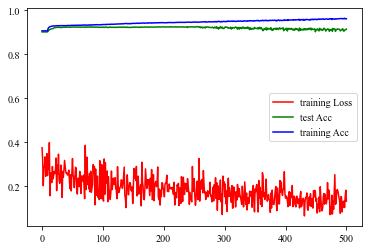

In [14]:
model2=train2(input,y_train,X_test,y_test,new_input,new_y_train)

In [ ]:
# plt.plot(epoch_list,loss_list,color='red',label='training Loss')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
#plt.plot(epoch_list,ans_acc_list,color='red',label='CNN_TCN_BiLSTM_Attention')
plt.plot(epoch_list2,ans_acc_list2,color='blue',label='CNN_TCN_BiGRU_Attention')
plt.yticks([0.8,0.85,0.90,0.95,1])
plt.legend()
plt.show()

In [ ]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.plot(epoch_list,loss_list,color='red',label='CNN_TCN_BiLSTM_Attention')
plt.plot(epoch_list2,loss_list2,color='blue',label='CNN_TCN_BiGRU_Attention')
# plt.yticks([0.8,0.85,0.90,0.95,1])
plt.legend()
plt.show()

In [ ]:
import xlwt
xl = xlwt.Workbook()
# 调用对象的add_sheet方法
sheet1 = xl.add_sheet('sheet1', cell_overwrite_ok=True)

sheet1.write(0, 0, "cnn_tcn_bigru_attention_accuracy")
sheet1.write(0, 1, 'cnn_tcn_bigru_attention_loss')


for i in range(0, len(ans_acc_list2)):
    sheet1.write(i + 1, 0, ans_acc_list2[i])
    sheet1.write(i + 1, 1, loss_list2[i])

xl.save("csv/cnn_tcn_bigru_attention.xlsx")